# Resolution Experimentation

In [1]:
import numpy as np
import anndata
import pandas as pd
import os
from src import preprocess, get_hg_reduction, reduce, scatterplot, knn_auto
import matplotlib.pyplot as plt
import igraph as ig
import leidenalg as la
from sklearn.metrics import adjusted_rand_score as ARI

/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Identify cell type columns in each dataset
DATA_LOG = {}
resolutions = [i/10 for i in range(5,16)]
cell_type_cols = [
    "cell.type",
    "level1 class",
    "cluster_label",
    "cell_types",
    "celltype",
    "cell type",
    "CellLine",
]

In [3]:
for dataset in os.listdir("data"):

    if (
        (dataset in DATA_LOG and len(DATA_LOG[dataset]) == len(resolutions) ** 2)
        or (not dataset.endswith('.h5ad'))
    ):
        continue
        
    print(f"Running {dataset}")
    
    dataset_fn = os.path.join("data", dataset)

    # Read in data
    adata = anndata.read_h5ad(dataset_fn)
    adata = preprocess(
        adata,
        filter_genes=True,
        normalize=True,
        log1p=True,
        high_var=True,
        scale=True,
    )
    
    if 'labels' not in adata.obs.columns:
        for c in cell_type_cols:
            if c in adata.obs.columns:
                adata.obs['labels'] = adata.obs[c]
                break
        if 'labels' not in adata.obs.columns:
            # Skip this dataset - cannot find cell type labels
            print(f"Couldn't find labels for {dataset}")
            continue

    # this is sparse
    reduced_adj = get_hg_reduction(adata.X, n_clusters=4)
    print(f"Adjacency matrix has shape {reduced_adj.shape}")

    order = np.argsort(adata.obs['labels']) # cells ordered so we can see blocks in the heatmap

    # Construct graph using reduced adj

    sources, targets = reduced_adj.nonzero()
    weights = np.array(reduced_adj[sources, targets])
    gg = ig.Graph(directed=False)
    gg.add_vertices(adata.shape[0]) # cells
    gg.add_edges(list(zip(list(sources), list(targets))))

    # Construct graph with KNN
    sources_base, targets_base, weights_base = knn_auto(adata.X)
    gg_base = ig.Graph(directed=False)
    gg_base.add_vertices(adata.shape[0]) # cells
    gg_base.add_edges(list(zip(list(sources_base), list(targets_base))))

    for res_reduced in resolutions:
    
        ## Run Leiden - Reduced Adj
        part = la.find_partition(
            gg,
            la.RBConfigurationVertexPartition,
            weights=weights.flatten(),
            resolution_parameter=res_reduced,
        )
        predictions_reduced_hg = np.array(part.membership, dtype=int)

        for res_base in resolutions:
        
            ## Run Leiden - KNN
            part_base = la.find_partition(
                gg_base,
                la.RBConfigurationVertexPartition,
                resolution_parameter=res_base,
            )
            predictions_base = np.array(part_base.membership, dtype=int)
            score_reduced = ARI(predictions_reduced_hg, adata.obs['labels'])
            score_base = ARI(predictions_base, adata.obs['labels'])

            if dataset not in DATA_LOG:
                DATA_LOG[dataset] = {}

            DATA_LOG[dataset][f"{res_reduced}_{res_base}"] = {
                'res_reduced': res_reduced,
                'res_base': res_base,
                'score_reduced': score_reduced,
                'score_base': score_base,
            }

Running darmanis_brain.h5ad
adata has shape (466, 22085)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (466, 5683)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5683/5683 [02:28<00:00, 38.29it/s]


Adjacency matrix has shape (466, 466)
Running romanov_brain.h5ad
adata has shape (2881, 24341)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (2881, 3729)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3729/3729 [03:46<00:00, 16.47it/s]


Adjacency matrix has shape (2881, 2881)
Running fletcher_olfactory.h5ad
adata has shape (616, 46988)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (616, 7786)


100%|██████████████████████████████████████████████| 7786/7786 [04:16<00:00, 30.41it/s]


Adjacency matrix has shape (616, 616)
Running zhong_prefrontal.h5ad
adata has shape (2394, 24153)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (2394, 3976)


100%|██████████████████████████████████████████████| 3976/3976 [05:25<00:00, 12.22it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (2394, 2394)
Running lawlow_pancreas.h5ad
adata has shape (638, 26616)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (638, 6382)


100%|██████████████████████████████████████████████| 6382/6382 [04:19<00:00, 24.63it/s]


Adjacency matrix has shape (638, 638)
Running hermann_spermatogenesis.h5ad
adata has shape (2325, 54448)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (2325, 3822)


100%|██████████████████████████████████████████████| 3822/3822 [04:25<00:00, 14.42it/s]


Adjacency matrix has shape (2325, 2325)


In [4]:
np.save('output/resolution_search.h5ad', DATA_LOG)

## Resolution Exploration

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [6]:
OPTIMAL_RES = {}
for dataset in DATA_LOG.keys():
    res_df = pd.DataFrame(DATA_LOG[dataset]).T
    res_df = res_df.sort_values(['score_base', 'score_reduced'], ascending=False)
    res = res_df.iloc[0].to_dict()
    res['dataset'] = dataset
    OPTIMAL_RES[dataset] = res

In [7]:
score_df = pd.DataFrame(OPTIMAL_RES).T

In [8]:
score_df

,res_reduced,res_base,score_reduced,score_base,dataset
darmanis_brain.h5ad,1.3,1.0,0.68788,0.63547,darmanis_brain.h5ad
romanov_brain.h5ad,0.9,0.7,0.719452,0.595981,romanov_brain.h5ad
fletcher_olfactory.h5ad,1.5,1.3,0.563479,0.320012,fletcher_olfactory.h5ad
zhong_prefrontal.h5ad,1.0,0.8,0.362129,0.170461,zhong_prefrontal.h5ad
lawlow_pancreas.h5ad,1.1,1.0,0.767902,0.118037,lawlow_pancreas.h5ad
hermann_spermatogenesis.h5ad,1.3,0.6,0.403438,0.350577,hermann_spermatogenesis.h5ad


### Highest-Achieved ARI

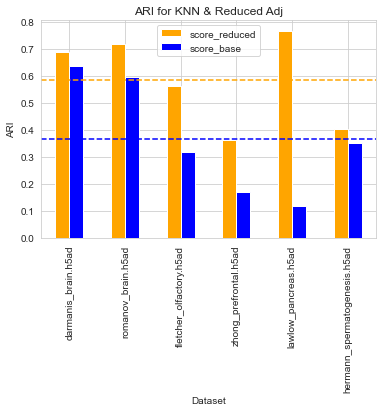

In [9]:
ax = score_df.plot.bar(x='dataset', y=['score_reduced', 'score_base'], color=['orange', 'blue'])
ax.set_ylabel("ARI")
ax.set_xlabel("Dataset")
ax.set_title("ARI for KNN & Reduced Adj")
plt.axhline(y=score_df['score_reduced'].mean(), color='orange', linestyle='--')
plt.axhline(y=score_df['score_base'].mean(), color='blue', linestyle='--')

### Optimal Resolution

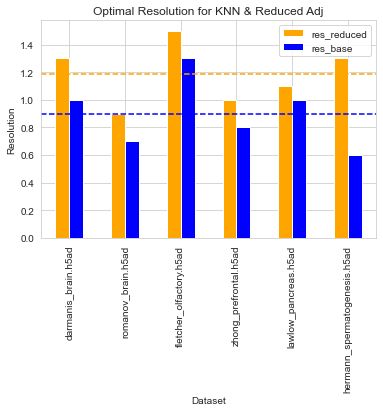

In [10]:
ax = score_df.plot.bar(x='dataset', y=['res_reduced', 'res_base'], color=['orange', 'blue'])
ax.set_ylabel("Resolution")
ax.set_xlabel("Dataset")
ax.set_title("Optimal Resolution for KNN & Reduced Adj")
plt.axhline(y=score_df['res_reduced'].mean(), color='orange', linestyle='--')
plt.axhline(y=score_df['res_base'].mean(), color='blue', linestyle='--')

### How ARI varied with resolution for each dataset

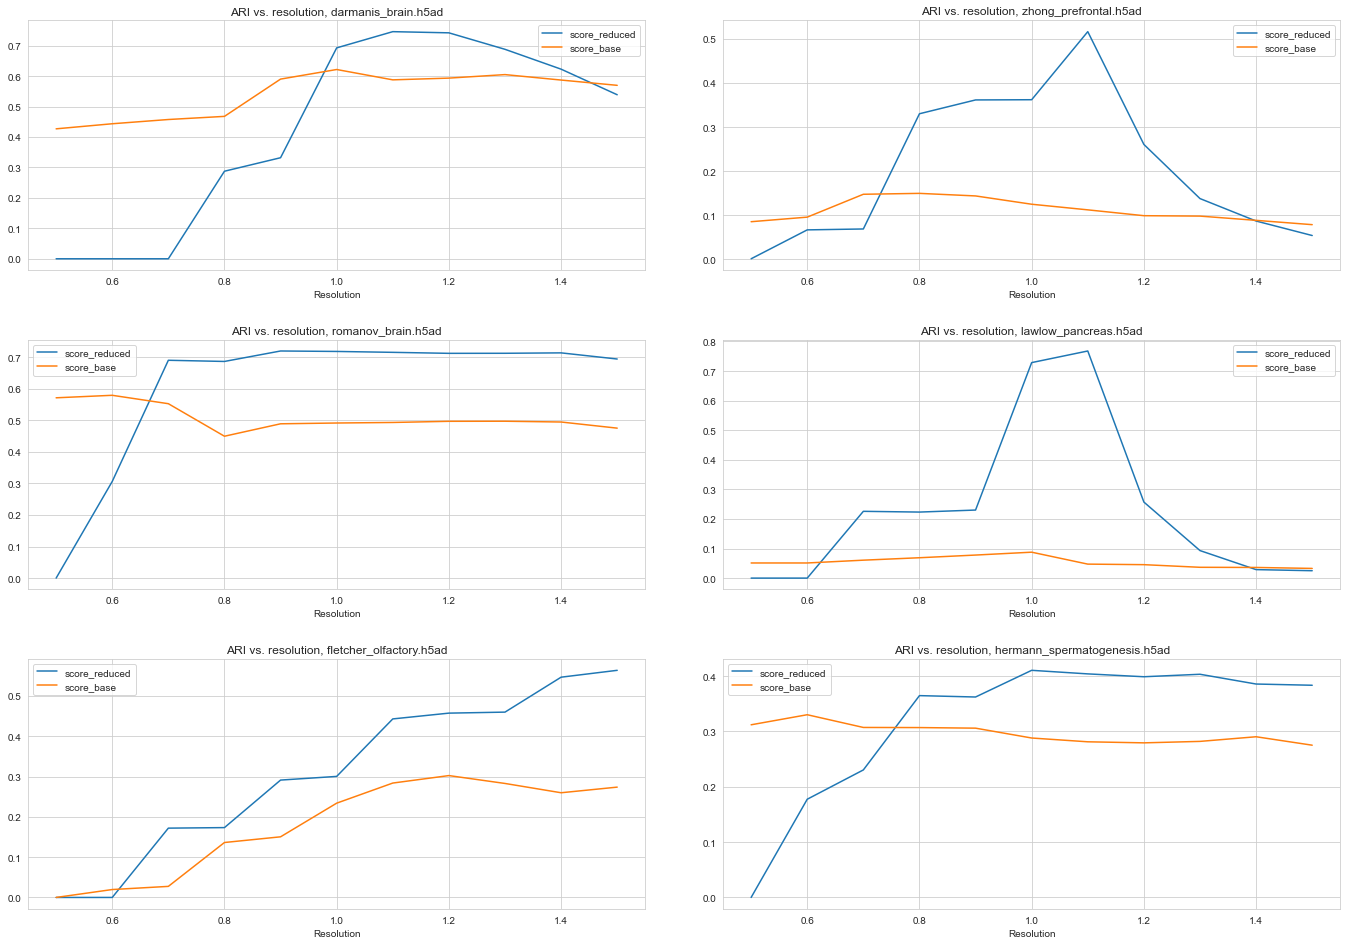

In [11]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(20, 14)
fig.tight_layout(pad=5)
for i, dataset in enumerate(DATA_LOG.keys()):
    ax = axs[i % 3, i // 3]
    log_df = pd.DataFrame(DATA_LOG[dataset]).T
    log_df.groupby('res_reduced').mean().plot(y='score_reduced', ax=ax)
    log_df.groupby('res_base').mean().plot(y='score_base', ax=ax)
    ax.set_title(f"ARI vs. resolution, {dataset}")
    ax.set_xlabel("Resolution")

Text(155.125, 0.5, 'ARI')

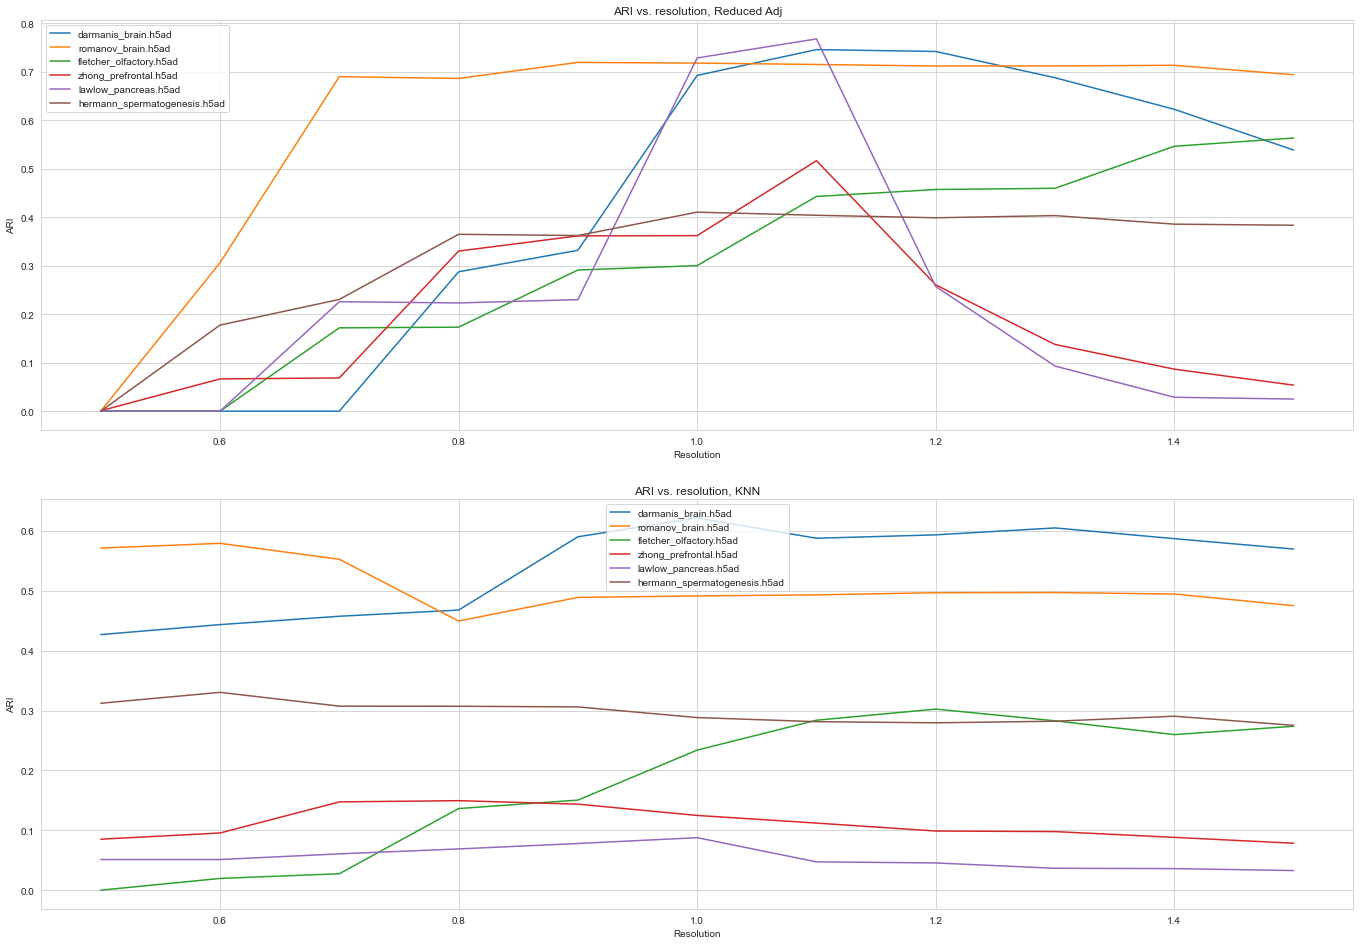

In [12]:
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(20, 14)
fig.tight_layout(pad=5)
for i, dataset in enumerate(DATA_LOG.keys()):
    log_df = pd.DataFrame(DATA_LOG[dataset]).T
    # Rename temp col to dataset to quickly set label of line
    log_df[dataset] = log_df['score_reduced']
    log_df.groupby('res_reduced').mean().plot(y=dataset, ax=axs[0])
    log_df[dataset] = log_df['score_base']
    log_df.groupby('res_base').mean().plot(y=dataset, ax=axs[1])

axs[0].set_title(f"ARI vs. resolution, Reduced Adj")
axs[0].set_xlabel("Resolution")
axs[0].set_ylabel("ARI")
axs[1].set_title(f"ARI vs. resolution, KNN")
axs[1].set_xlabel("Resolution")
axs[1].set_ylabel("ARI")